In [2]:
from ase.io.trajectory import TrajectoryReader as tr

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from publish_format import useLargeSize

import re

In [3]:
color = {"DFT": "k",
         "AMPtorch DFT\n(with force)": "tab:orange",
         "AMPtorch DFT\n(without force)": "tab:blue",
         "AMPtorch DMC": "tab:red"}

In [4]:
def extract_forces(filename):
    forces = []
    trajs = tr(filename)
    for traj in trajs:
        forces.append(np.linalg.norm(np.array(traj.get_forces())))
    return np.array(forces)


def extract_geom(filename):
    '''
    "C C"
    '''
    d_c_c = []
    
    trajs = tr(filename)
    for traj in trajs:
        d_c_c.append(traj.get_distances(0, 1)[0])
        
    data = pd.DataFrame(
        {r"$d_{C-C}$": d_c_c, 
         }
    )
    return data

## NVE results analysis

Define the corresponding NVE trajectories

In [5]:
file = {}

file["DFT"] = "./nve_data/dft/md_nve_dft.traj"
file["AMPtorch DFT\n(with force)"] = "./nve_data/amptorch_dft_force/md_nve_amptorch.traj"
file["AMPtorch DFT\n(without force)"] = "./nve_data/amptorch_dft_noforce/md_nve_amptorch.traj"
file["AMPtorch DMC"] = "./nve_data/amptorch_dmc/md_nve_amptorch.traj"

In [6]:
# show the running time for each trajectories
for item in file:
    print(item, " has length ", len(tr(file[item])))

DFT  has length  201
AMPtorch DFT
(with force)  has length  20001
AMPtorch DFT
(without force)  has length  20001
AMPtorch DMC  has length  20001


Check starting structures

In [7]:
for item in file:
    print(item)
    print(tr(file[item])[0].get_positions())

DFT
[[6.87899729 7.49999705 7.49999705]
 [8.1209968  7.49999705 7.49999705]]
AMPtorch DFT
(with force)
[[6.87899729 7.49999705 7.49999705]
 [8.1209968  7.49999705 7.49999705]]
AMPtorch DFT
(without force)
[[6.87899729 7.49999705 7.49999705]
 [8.1209968  7.49999705 7.49999705]]
AMPtorch DMC
[[6.87899729 7.49999705 7.49999705]
 [8.1209968  7.49999705 7.49999705]]


### Extract mean values for the observables

In [7]:
for item in file:
    geom = extract_geom(file[item])
    print(item)
    print(geom.mean())

DFT
$d_{C-C}$    1.271981
dtype: float64
AMPtorch DFT
(with force)
$d_{C-C}$    1.263462
dtype: float64
AMPtorch DFT
(without force)
$d_{C-C}$    1.264678
dtype: float64
AMPtorch DMC
$d_{C-C}$    1.246921
dtype: float64


### Plot the Energy trajectory

In [8]:
def extract_total_energy(filename):
    energy = []
    trajs = tr(filename)
    for traj in trajs:
        energy.append(traj.get_total_energy())
    return np.array(energy)

tot_e = {}
for item in file:
    tot_e[item] = extract_total_energy(file[item])
    tot_e[item] -= np.min(tot_e[item])
    # tot_e[item] /= 5

In [9]:
def extract_potential_energy(filename):
    energy = []
    trajs = tr(filename)
    for traj in trajs:
        energy.append(traj.get_potential_energy())
    return np.array(energy)

pot_e = {}
for item in file:
    pot_e[item] = extract_potential_energy(file[item])
    pot_e[item] -= min(pot_e[item])

In [10]:
def extract_kinetic_energy(filename):
    energy = []
    trajs = tr(filename)
    for traj in trajs:
        energy.append(traj.get_kinetic_energy())
    return np.array(energy)

kin_e = {}
for item in file:
    kin_e[item] = extract_kinetic_energy(file[item])

Plot the $E_{tot}$ v.s. Time

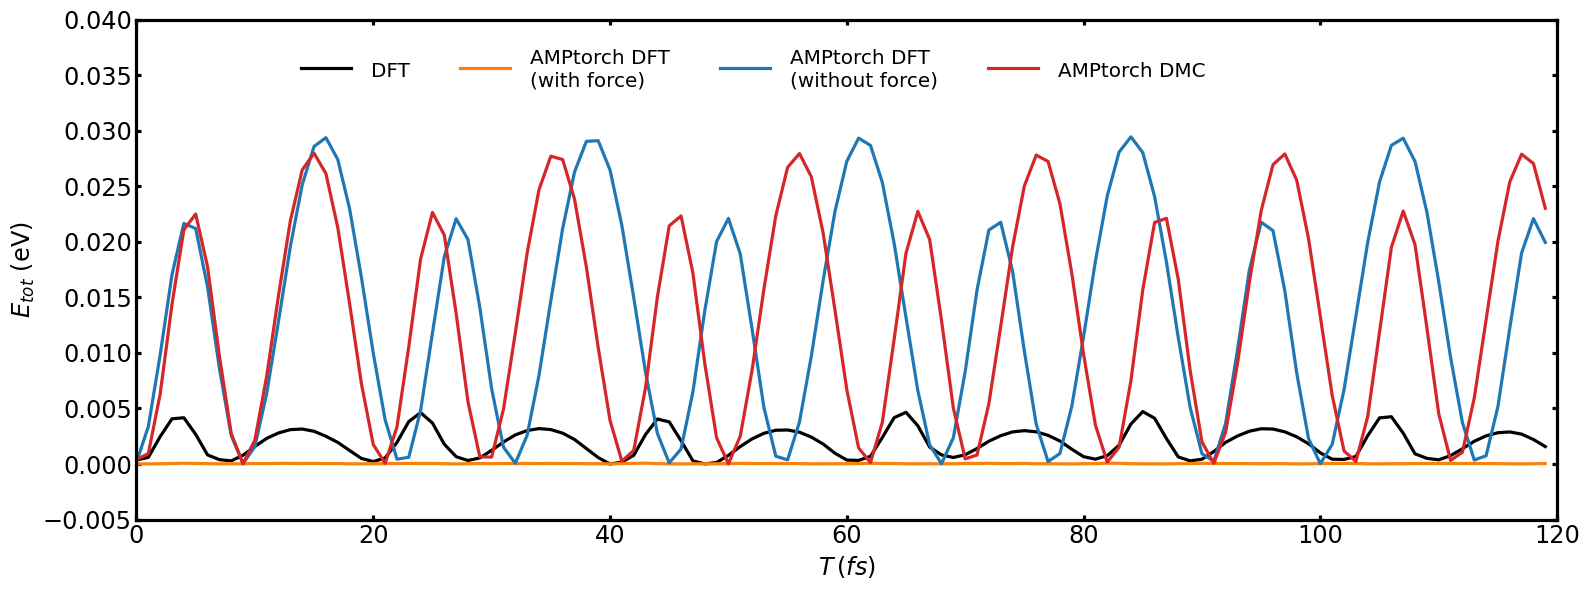

In [11]:
plot_data = tot_e

start, end = 0, min(1000, len(plot_data["DFT"]))
start, end = 0, 120
time = np.arange(end)
figname = "c2_nve_etot_{}.png".format(end)
xlabel = r"$T\,(fs)$"
ylabel = r"$E_{tot}$ (eV)"
# ylabel = r"Relative Energy (eV/atom)"

plt.style.use('default')
fig, ax = plt.subplots(figsize=(16,6))

for item in plot_data:
    if item == "AMPtorch DFT\n(with force)":
        ax.plot(time, 
                plot_data[item][start:end],
                c=color[item],
                # linestyle="dashed",
                label=item)
    else:
        ax.plot(time, 
                plot_data[item][start:end],
                c=color[item],
                label=item)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(loc='center left', bbox_to_anchor=(0.1, 0.9), frameon=False, fontsize=18, ncol=4)
ax.set_xlim(start, end)
ax.set_ylim(-0.005, 0.04)
useLargeSize(plt, ax)
plt.savefig("./nve_data/{}".format(figname), dpi=300)

plot $E_{tot}$ distribution

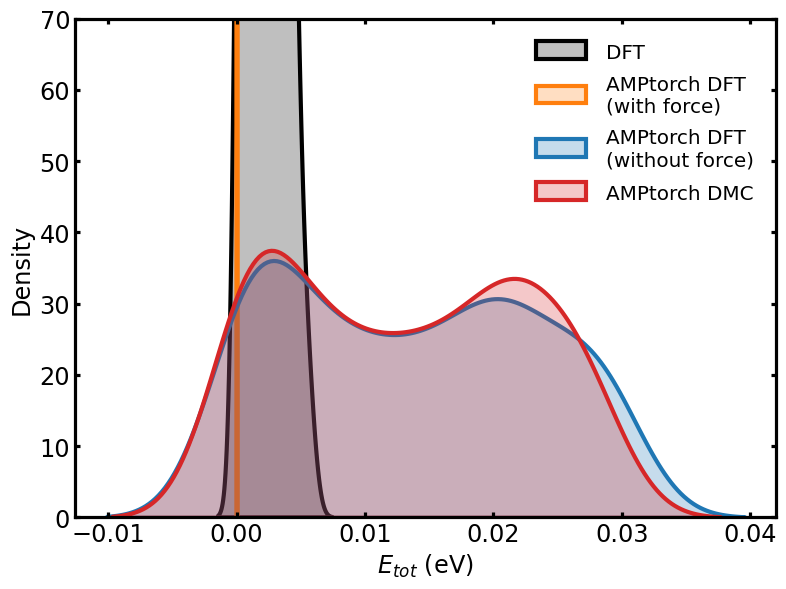

In [44]:
plot_data = tot_e
figname = "c2_nve_etot_distribution.png"
ylabel = r"Density"
xlabel = r"$E_{tot}$ (eV)"

plt.style.use('default')
fig, ax = plt.subplots(figsize=(8,6))

for item in plot_data:
    sns.kdeplot(plot_data[item][:200], 
                shade = True, 
                linewidth = 3, 
                bw_adjust = 1, 
                label = item, 
                color = color[item],
            )

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(frameon=False, fontsize=18)
ax.set_ylim(0, 70)
useLargeSize(plt, ax)
plt.savefig("./nve_data/{}".format(figname), dpi=300)

plot $E_{pot}$ v.s. time

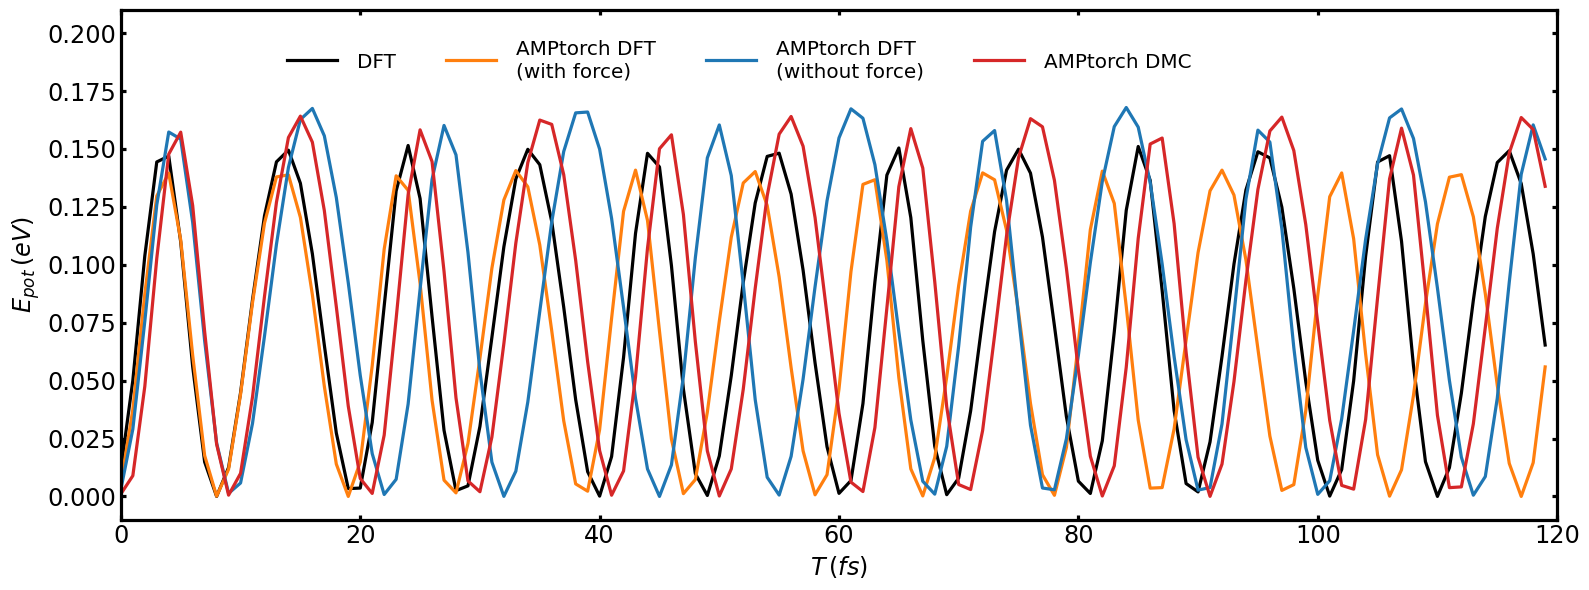

In [12]:
plot_data = pot_e

# start, end = 0, min(1000, len(plot_data["DFT"]))
start, end = 0, 120
time = np.arange(end)
figname = "c2_nve_epot_{}.png".format(end)
xlabel = r"$T\,(fs)$"
ylabel = r"$E_{pot}\,(eV$)"

plt.style.use('default')
fig, ax = plt.subplots(figsize=(16,6))

for item in plot_data:
    if item == "AMPtorch DFT\n(with force)":
        ax.plot(time, 
                plot_data[item][start:end],
                c=color[item],
                # linestyle="dashed",
                label=item)
    else:
        ax.plot(time, 
                plot_data[item][start:end],
                c=color[item],
                label=item)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(loc='center left', bbox_to_anchor=(0.1, 0.9), frameon=False, fontsize=18, ncol=4)
ax.set_xlim(start, end)
ax.set_ylim(-0.01, 0.21)
useLargeSize(plt, ax)
plt.savefig("./nve_data/{}".format(figname), dpi=300)

plot $E_{pot}$ distribution

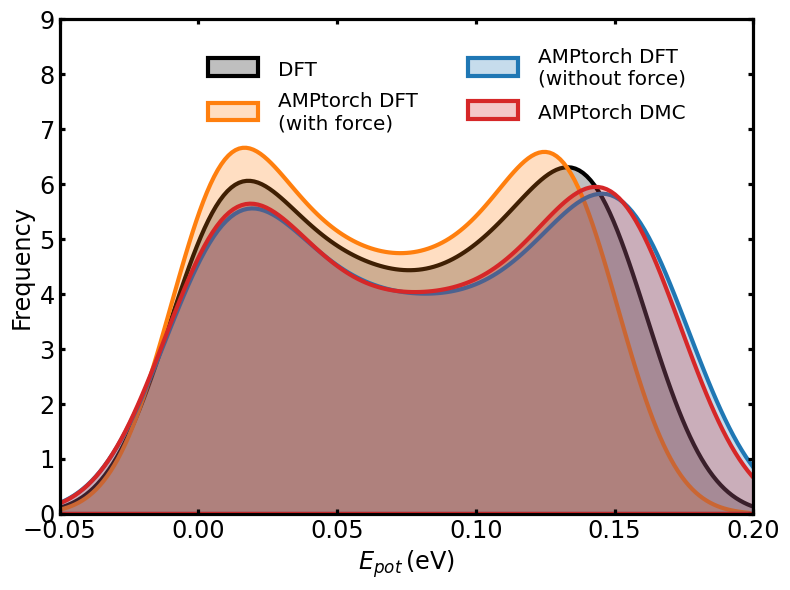

In [75]:
plot_data = pot_e
figname = "c2_nve_epot_distribution.png"
ylabel = r"Frequency"
xlabel = r"$E_{pot}\,$(eV)"

plt.style.use('default')
fig, ax = plt.subplots(figsize=(8,6))

for item in plot_data:
    sns.kdeplot(plot_data[item][:120], 
                shade = True, 
                linewidth = 3, 
                bw_adjust = 1, 
                label = item, 
                color = color[item],
            )

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(loc=(0.2, 0.75), frameon=False, fontsize=18, ncol=2)
ax.set_xlim(-0.05, 0.2)
ax.set_ylim(0, 9)
useLargeSize(plt, ax)
plt.savefig("./nve_data/{}".format(figname), dpi=300)

plot $E_{kin}$ v.s. Time

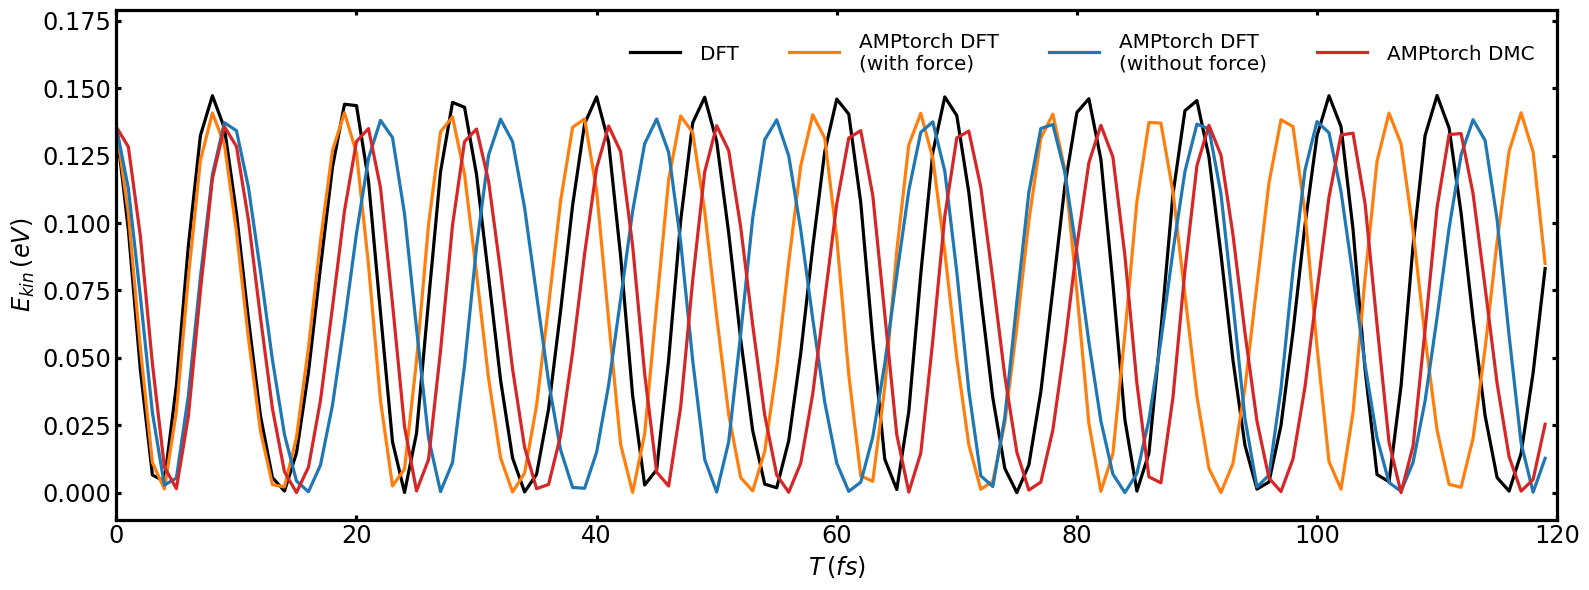

In [76]:
plot_data = kin_e

start, end = 0, min(1000, len(plot_data["DFT"]))
start, end = 0, 120
time = np.arange(end)
figname = "c2_nve_ekin_{}.png".format(end)
xlabel = r"$T\,(fs)$"
ylabel = r"$E_{kin}\,(eV$)"

plt.style.use('default')
fig, ax = plt.subplots(figsize=(16,6))

for item in plot_data:
    ax.plot(time, 
            plot_data[item][start:end],
            c=color[item],
            label=item)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(frameon=False, fontsize=18, ncol=4)
ax.set_xlim(start, end)
ax.set_ylim(-0.01, 0.179)
useLargeSize(plt, ax)
plt.savefig("./nve_data/{}".format(figname), dpi=300)

plot $E_{kin}$ distribution

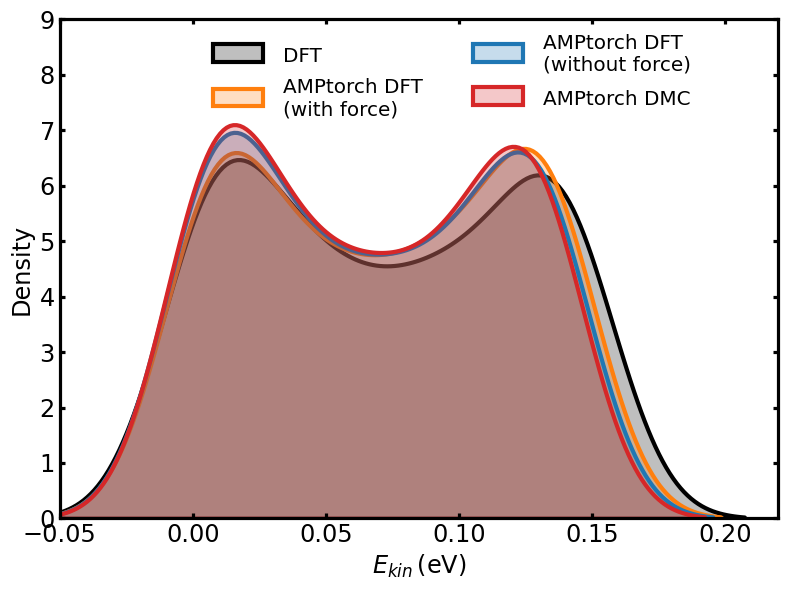

In [77]:
plot_data = kin_e
figname = "c2_nve_ekin_distribution.png"
ylabel = r"Density"
xlabel = r"$E_{kin}\,$(eV)"

plt.style.use('default')
fig, ax = plt.subplots(figsize=(8,6))

for item in plot_data:
    sns.kdeplot(plot_data[item][:120], 
                shade = True, 
                linewidth = 3, 
                bw_adjust = 1, 
                label = item, 
                color = color[item],
            )

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.tick_params(axis="y")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.legend(loc=(0.2, 0.78), frameon=False, fontsize=18, ncol=2)
ax.set_xlim(-0.05, 0.22)
ax.set_ylim(0, 9)
useLargeSize(plt, ax)
plt.savefig("./nve_data/{}".format(figname), dpi=300)

### Plot geometry v.s. time

In [40]:
data = {}

for item in file:
    data[item] = extract_geom(file[item])

observables = data[item].columns

plot observables v.s. time

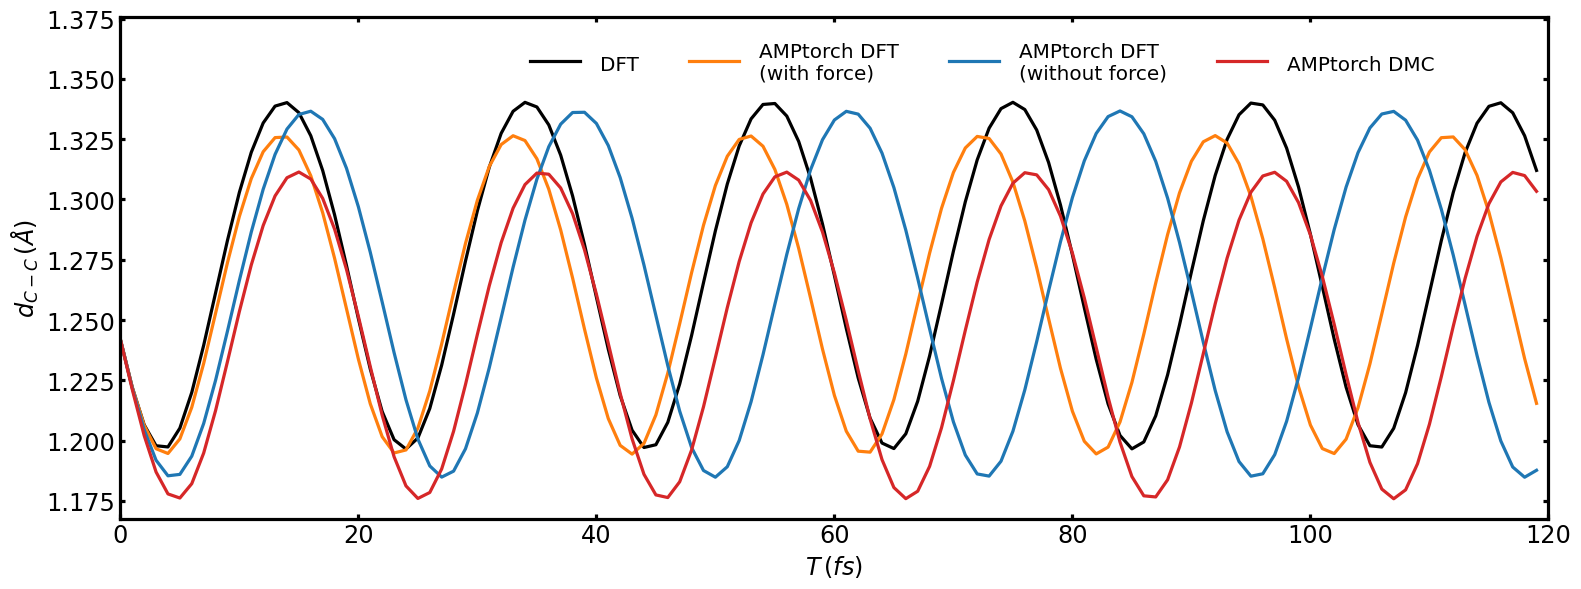

In [78]:
for observable in observables:
    plot_data = {}
    for item in file:
        plot_data[item] = data[item][observable]

    xlabel = r"$T\,(fs)$"
    if "d" in observable:
        ylabel = observable + r"$\,({\AA})$"
    if "theta" in observable:
        ylabel = observable + r"$\,(degree)$"


    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(16,6))

    min_len = float("inf")
    for item in plot_data:
        min_len = min(min_len, len(plot_data[item]))
    # start, end = 0, min(1000, min_len)
    start, end = 0, 120
    time = np.arange(end)

    for item in plot_data:
        ax.plot(time, 
                plot_data[item][start:end], 
                c=color[item], 
                label=item,
                )

    ax.set_xlabel(xlabel=xlabel)
    ax.set_ylabel(ylabel=ylabel)
    ax.tick_params(axis="y")
    ax.yaxis.set_ticks_position("both")
    ax.xaxis.set_ticks_position("both")
    ax.legend(loc=(0.28, 0.85), frameon=False, fontsize=18, ncol=4)
    ax.set_xlim(start, end)
    bottom, up = ax.get_ylim()
    ax.set_ylim(bottom, 1.02 * up)
    # ax.set_ylim(1.68, 2.21)
    useLargeSize(plt, ax)
    new_observable = ""
    for i in observable:
        if i not in {"\\","$", "{", "}", "-"}:
            new_observable += i 
    figname = "c2_nve_{}.png".format(new_observable)
    # print(figname)
    plt.savefig("./nve_data/{}".format(figname), dpi=300)
    

plot observables distribution

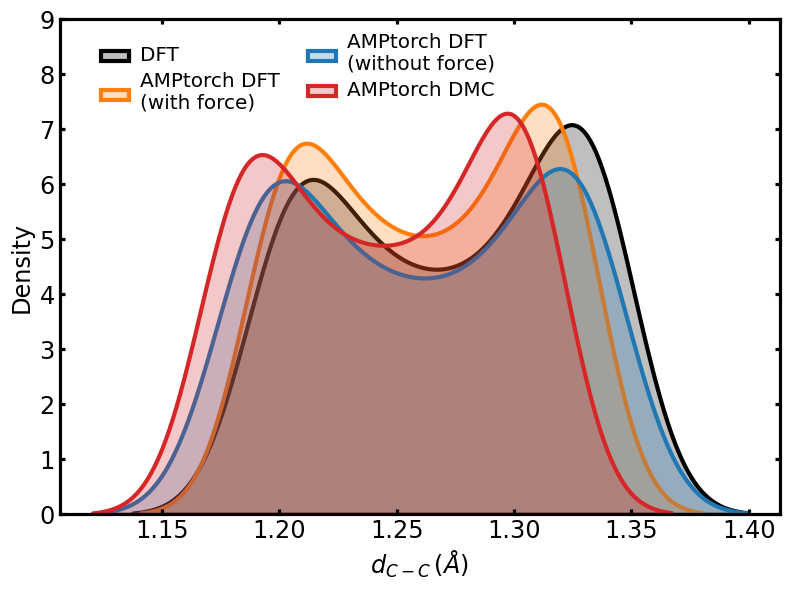

In [79]:
for observable in observables:
    plot_data = {}
    for item in file:
        plot_data[item] = data[item][observable]

    if "d" in observable:
        xlabel = observable + r"$\,({\AA})$"
    if "theta" in observable:
        xlabel = observable + r"$\,(degree)$"
    ylabel = "Density"

    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(8,6))

    for item in plot_data:
        sns.kdeplot(plot_data[item][:120], 
                    shade = True, 
                    linewidth = 3, 
                    bw_adjust = 1, 
                    label = item, 
                    color = color[item],
                )

    ax.set_xlabel(xlabel=xlabel)
    ax.set_ylabel(ylabel=ylabel)
    ax.tick_params(axis="y")
    ax.yaxis.set_ticks_position("both")
    ax.xaxis.set_ticks_position("both")
    ax.legend(loc=(0.05, 0.8), frameon=False, ncol=2)
    ax.set_ylim(0, 9)
    if "Cl-C-H_{1}" in observable:
        left, right = ax.get_xlim()
        ax.set_xlim(left - 10, right)
    if "Cl-C-H" in observable:
        ax.legend(loc=(0.05, 0.6), frameon=False)
    if re.match(r".*H_{.*}-C-H_{.*}.*", observable):
        left, right = ax.get_xlim()
        ax.set_xlim(left, right + 5)

    useLargeSize(plt, ax)
    new_observable = ""
    for i in observable:
        if i not in {"\\","$", "{", "}", "-"}:
            new_observable += i 
    figname = "c2_nve_{}_distribution.png".format(new_observable)
    # print(figname)
    plt.savefig("./nve_data/{}".format(figname), dpi=300)